In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".4"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import distrax

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell, _compute_num_kids, _compute_index_of_kid, compute_levels
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection, Connectivity
from neurax.utils.plot_utils import plot_morph
from neurax.mechanisms.hh_neuron import hh_neuron_gate
from neurax.mechanisms.glutamate_synapse import glutamate
from neurax.cell import merge_cells

In [22]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# Setup

### Params for all cells

In [143]:
r_a = 10_000  # ohm cm 
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 15.0  # ms

nseg_per_branch = 4

### Individual params

In [153]:
# Cell 1
num_branches1 = 15
ncomp1 = num_branches1 * nseg_per_branch
parents1 = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents1) == num_branches1
lengths1 = [100.0] * num_branches1
radiuses1 = [10.0] * num_branches1
cell1 = Cell(num_branches1, parents1, nseg_per_branch, lengths1, radiuses1, r_a)

# Cell 2
num_branches2 = 7
ncomp = num_branches2 * nseg_per_branch
parents2 = jnp.asarray([-1, 0, 0, 1, 1, 2, 2])
assert len(parents2) == num_branches2
lengths2 = [50.0] * num_branches2
initial_radius = 3.0
radiuses2 = [5.0] * num_branches2 + [initial_radius]  # Append because parent=-1 will access last one.
cell2 = Cell(num_branches2, parents2, nseg_per_branch, lengths2, radiuses2, r_a)

rad_of_each_comp (60,)


AttributeError: 'Cell' object has no attribute 'radiuses'

In [127]:
# Initialize voltage
init_v = [
    jnp.asarray([-62.0] * num_branches1*nseg_per_branch), 
    jnp.asarray([-62.0] * num_branches2*nseg_per_branch),
]

# Initialize states
hh_states = [
    jnp.stack(
        [
            jnp.asarray([0.074901] * num_branches1*nseg_per_branch), 
            jnp.asarray([0.4889] * num_branches1*nseg_per_branch),
            jnp.asarray([0.3644787] * num_branches1*nseg_per_branch),
        ]
    ),
    jnp.stack(
        [
            jnp.asarray([0.074901] * num_branches2*nseg_per_branch), 
            jnp.asarray([0.4889] * num_branches2*nseg_per_branch),
            jnp.asarray([0.3644787] * num_branches2*nseg_per_branch),
        ]
    ),
]

### Set up model

In [128]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

In [129]:
cells = [cell1, cell2]
recs = [
    Recording(0, 0, 0.0),
    Recording(0, 10, 1.0),
    Recording(1, 0, 0.0),
    Recording(1, 5, 1.0),
]
conns = [Connection(0, 0, 0.0, 1, 0, 0.0)]
connectivities = [Connectivity(conns, nseg_per_branch)]
stims = [Stimulus(0, 0, 0.0, current=step_current(i_delay, i_dur, i_amp, time_vec))]

### Define parameters

In [130]:
hh_params = [
    jnp.stack(
        [
            jnp.asarray([0.12] * num_branches1*nseg_per_branch), 
            jnp.asarray([0.036] * num_branches1*nseg_per_branch),
            jnp.asarray([0.0003] * num_branches1*nseg_per_branch),
        ]
    ),
    jnp.stack(
        [
            jnp.asarray([0.12] * num_branches2*nseg_per_branch), 
            jnp.asarray([0.036] * num_branches2*nseg_per_branch),
            jnp.asarray([0.0003] * num_branches2*nseg_per_branch),
        ]
    ),
]

synapse_params = jnp.asarray([1.0] * len(conns))

### ODE

In [131]:
mem_channels = [hh_neuron_gate,]
mem_states = [hh_states,]
mem_params = [hh_params,]

In [132]:
syn_channels = [glutamate,]
syn_states = [jnp.zeros((len(conns))),]
syn_params = [synapse_params,]

In [133]:
s = solve(
    cells,
    connectivities,
    init_v,
    mem_states=mem_states,
    mem_params=mem_params,
    mem_channels=mem_channels,
    syn_states=syn_states,
    syn_params=syn_params,
    syn_channels=syn_channels,
    stimuli=stims,
    recordings=recs,
    t_max=t_max,
    dt=dt,
    solver="stone",
    checkpoint_inds=[]
)

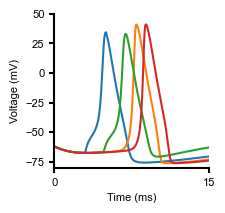

In [134]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    for i in range(4):
        _ = ax.plot(time_vec, s[i])
    _ = ax.set_ylim([-80, 50])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticks([0, max(time_vec)])
    ax.set_xlim([0, max(time_vec)])
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    plt.subplots_adjust(hspace=0.4)
#     plt.savefig("../../results/response.png", dpi=200, bbox_inches="tight")
    plt.show()

In [135]:
print("s[0]", s[0][::10])

s[0] [-62.         -62.99870784 -63.87120085 -64.65065038 -65.33046381
 -65.90368979 -66.37102246 -66.73954656 -67.01986751 -67.22379634
 -67.36291788 -67.44785485 -67.48797528 -59.19880487 -54.98517321
 -51.46835824 -47.12595557 -39.42750684 -20.16709809  20.04021694
  34.24327567  25.33949948  13.05931365   0.11767902 -12.12599233
 -23.33265571 -33.74763672 -44.18456358 -55.61437271 -66.30872845
 -72.12233856 -74.23351966 -75.05733287 -75.47450469 -75.66574463
 -75.70257673 -75.65405168 -75.56317459 -75.44846101 -75.31495093
 -75.16489383 -75.00069412 -74.824443   -74.63745446 -74.44046401
 -74.23402591 -74.01872933 -73.79523948 -73.56427097 -73.32656069
 -73.08285531 -72.83390711 -72.58047181 -72.32330533 -72.0631593
 -71.8007756  -71.53688066 -71.27217997 -71.00735304 -70.74304924
 -70.47988431]


In [136]:
print("s[1]", s[1][::10])

s[1] [-62.         -62.99870784 -63.87120085 -64.65065038 -65.33046381
 -65.90368979 -66.37102246 -66.73954656 -67.01986751 -67.22379634
 -67.36291788 -67.44785485 -67.48797528 -67.49134962 -67.46482604
 -67.41408242 -67.34358143 -67.25668822 -67.15601117 -67.04364829
 -66.92104776 -66.78802609 -66.64017574 -66.46407927 -66.2255954
 -65.84279313 -65.13906001 -63.67412908 -60.38820775 -52.99371046
 -33.12427403  21.47957891  40.33402827  32.23592245  20.18457447
   7.1172336   -5.54226027 -17.3913516  -28.65934344 -40.39552469
 -54.95575928 -70.31767095 -75.63324883 -76.16404356 -76.13425752
 -76.03589845 -75.91849554 -75.788213   -75.64575598 -75.49101732
 -75.3238181  -75.14406031 -74.95176908 -74.74710822 -74.53038598
 -74.30205507 -74.06270788 -73.81306749 -73.553975   -73.28637369
 -73.01129093]


In [137]:
print("s[2]", s[2][::10])

s[2] [-62.         -62.9969479  -63.8655094  -64.63999781 -65.31437164
 -65.88200962 -66.34378334 -66.70685512 -66.98185134 -67.18057631
 -67.31459701 -67.39451544 -67.42967978 -67.42769188 -67.39342987
 -67.33133169 -67.24478452 -67.13399154 -66.98141641 -66.2361428
 -60.23833608 -55.92777474 -52.92308989 -49.70058641 -44.89972232
 -35.1036895   -9.13720399  27.66540216  31.64693725  22.06845246
   9.57850946  -2.96909871 -14.60484051 -25.15749315 -34.92190388
 -44.63262596 -54.95376851 -64.17716198 -68.92133553 -70.32747493
 -70.64048195 -70.59733766 -70.355624   -70.0051958  -69.60447772
 -69.1810837  -68.74444018 -68.29872204 -67.84770337 -67.39496493
 -66.94345158 -66.49539773 -66.05250138 -65.61609902 -65.18727183
 -64.7669008  -64.35569618 -63.95421671 -63.56288566 -63.18200642
 -62.81177838]


In [138]:
print("s[3]", s[3][::10])

s[3] [-62.         -62.99870784 -63.87120076 -64.65064918 -65.33045754
 -65.90366998 -66.37097617 -66.73945794 -67.01971961 -67.22357258
 -67.36260298 -67.44743515 -67.48743878 -67.49068581 -67.46403246
 -67.41325344 -67.34318863 -67.25788295 -67.160712   -67.05448913
 -66.94152363 -66.82310985 -66.69744222 -66.55989027 -66.40682648
 -66.23679755 -66.04810188 -65.83291824 -65.56012658 -65.13541412
 -64.33123908 -62.55788683 -58.45868976 -48.67316654 -19.94131638
  36.2374293   38.5190016   28.68936504  16.0992362    3.08499454
  -9.31268917 -20.91520793 -32.14415784 -44.44731654 -60.10673773
 -73.07476979 -75.95920552 -76.17357584 -76.10900272 -76.00313631
 -75.88145005 -75.74716433 -75.60049753 -75.44122288 -75.26910923
 -75.08402226 -74.88595787 -74.67505757 -74.45161608 -74.21608329
 -73.96906112]
